<a href="https://colab.research.google.com/github/rontalapoojareddy/ADS_Assignment/blob/main/ADS_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
'''Date: 29-10-2025
Lab-3 Assignment
Name: Rontala Pooja Reddy
HTNO: 2503B05130
Mtech - 1st year'''
import pandas as pd
import numpy as np

data = pd.DataFrame({
    'Age': [70, 65, 60, 55, 45, 40, 35, 30],
    'Treated': [1, 1, 1, 1, 0, 0, 0, 0],
    'BP': [120, 118, 115, 117, 122, 125, 126, 124],
    'Propensity': [0.9, 0.85, 0.75, 0.6, 0.4, 0.25, 0.2, 0.1]
})

data['Weight'] = np.where(data['Treated'] == 1,
                          1 / data['Propensity'],
                          1 / (1 - data['Propensity']))

treated = np.average(data.loc[data.Treated == 1, 'BP'],
                     weights=data.loc[data.Treated == 1, 'Weight'])

control = np.average(data.loc[data.Treated == 0, 'BP'],
                     weights=data.loc[data.Treated == 0, 'Weight'])

print("Weighted BP (Treated):", round(treated, 2))
print("Weighted BP (Control):", round(control, 2))
print("Treatment Effect (Bias Corrected):", round(treated-control,2))

Weighted BP (Treated): 117.35
Weighted BP (Control): 124.09
Treatment Effect (Bias Corrected): -6.74


In [3]:
import pandas as pd
import numpy as np
import os

# Path to your file
file_path = r"/content/titanic3.xls"

# Read Excel (.xls needs xlrd engine)
df = pd.read_excel(file_path, engine='xlrd')

# Keep only the needed columns (drop rows with missing important fields)
cols = ["survived", "pclass", "sex", "age", "fare", "embarked"]
df = df[cols].dropna().copy()

# Define treatment, covariates, outcome
df["treated"] = (df["pclass"] == 1).astype(int)  # 1st class = treated
X_cols = ["sex", "age", "fare", "embarked"]
y_col = "survived"

print("✅ Data loaded:", df.shape)
df.head()

✅ Data loaded: (1043, 7)


,survived,pclass,sex,age,fare,embarked,treated
0,1,1,female,29.0000,211.3375,S,1
1,1,1,male,0.9167,151.5500,S,1
2,0,1,female,2.0000,151.5500,S,1
3,0,1,male,30.0000,151.5500,S,1
4,0,1,female,25.0000,151.5500,S,1


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

X = df[X_cols]
T = df["treated"].astype(int)

# Preprocess: one-hot for categoricals, scale numerics
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), ["sex", "embarked"]),
        ("num", StandardScaler(), ["age", "fare"]),
    ],
    remainder="drop"
)

logit = LogisticRegression(max_iter=2000, solver="lbfgs")
ps_model = Pipeline([("prep", preprocess), ("logit", logit)])

ps_model.fit(X, T)
df["propensity"] = ps_model.predict_proba(X)[:, 1]

print("Propensity AUC (discrimination of T):", round(roc_auc_score(T, df["propensity"]), 3))
df[["treated", "propensity"]].head(10)

Propensity AUC (discrimination of T): 0.97


,treated,propensity
0,1,0.999999
1,1,0.998559
2,1,0.998352
3,1,0.999884
4,1,0.999775
5,1,0.372368
6,1,0.994112
7,1,0.024916
8,1,0.870315
9,1,0.993141


In [5]:
# 3) IPW Weights: basic, stabilized, and clipped

# Basic IPW
w_basic = np.where(T == 1, 1.0 / df["propensity"], 1.0 / (1.0 - df["propensity"]))

# Stabilized IPW: multiply by marginal P(T=1) to reduce variance
p_t = T.mean()
w_stab = np.where(T == 1, p_t / df["propensity"], (1 - p_t) / (1.0 - df["propensity"]))

# Optionally clip extreme weights for stability (common in practice)
clip_lo, clip_hi = 0.1, 10.0
w_clip = np.clip(w_stab, clip_lo, clip_hi)

df["w_basic"] = w_basic
df["w_stab"] = w_stab
df["w_clip"] = w_clip

df[["treated", "propensity", "w_basic", "w_stab", "w_clip"]].head(10)

,treated,propensity,w_basic,w_stab,w_clip
0,1,0.999999,1.000001,0.270374,0.270374
1,1,0.998559,1.001443,0.270764,0.270764
2,1,0.998352,1.001651,0.270820,0.270820
3,1,0.999884,1.000116,0.270405,0.270405
4,1,0.999775,1.000225,0.270435,0.270435
5,1,0.372368,2.685519,0.726094,0.726094
6,1,0.994112,1.005923,0.271975,0.271975
7,1,0.024916,40.134849,10.851417,10.000000
8,1,0.870315,1.149009,0.310662,0.310662
9,1,0.993141,1.006907,0.272241,0.272241


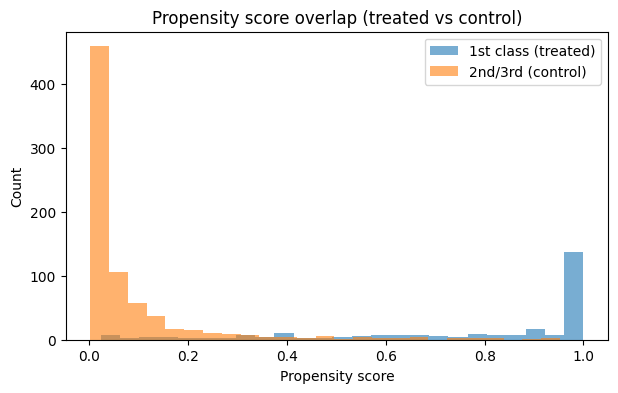

Propensity range: 0.002 to 1.0


In [6]:
# 4) Overlap check (distributions of propensity by group)

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.hist(df.loc[df["treated"] == 1, "propensity"], bins=25, alpha=0.6, label="1st class (treated)")
plt.hist(df.loc[df["treated"] == 0, "propensity"], bins=25, alpha=0.6, label="2nd/3rd (control)")
plt.xlabel("Propensity score")
plt.ylabel("Count")
plt.title("Propensity score overlap (treated vs control)")
plt.legend()
plt.show()

print("Propensity range:", round(df["propensity"].min(), 3), "to", round(df["propensity"].max(), 3))

In [7]:
# 5) Covariate balance (Standardized Mean Differences) before vs after IPW

def weighted_mean_var(x, w):
    m = np.sum(x * w) / np.sum(w)
    v = np.sum(w * (x - m) ** 2) / (np.sum(w) - 1) if np.sum(w) > 1 else 0.0
    return m, v

def smd_unweighted(x, t):
    x1, x0 = x[t == 1], x[t == 0]
    m1, m0 = x1.mean(), x0.mean()
    s1, s0 = np.std(x1, ddof=1), np.std(x0, ddof=1)
    sp = np.sqrt(((len(x1) - 1) * s1*2 + (len(x0) - 1) * s0*2) / (len(x1) + len(x0) - 2))
    return (m1 - m0) / sp if sp > 0 else 0.0

def smd_weighted(x, t, w):
    x1, x0 = x[t == 1], x[t == 0]
    w1, w0 = w[t == 1], w[t == 0]
    m1, v1 = weighted_mean_var(x1, w1)
    m0, v0 = weighted_mean_var(x0, w0)
    sp = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / sp if sp > 0 else 0.0

num_cols = ["age", "fare"]  # numeric covariates to check balance
bal = []
for col in num_cols:
    x = df[col].values
    t = df["treated"].values
    bal.append({
        "covariate": col,
        "SMD_unweighted": round(smd_unweighted(x, t), 3),
        "SMD_IPW_stabilized": round(smd_weighted(x, t, df["w_stab"].values), 3),
        "SMD_IPW_clipped": round(smd_weighted(x, t, df["w_clip"].values), 3),
    })

pd.DataFrame(bal)

,covariate,SMD_unweighted,SMD_IPW_stabilized,SMD_IPW_clipped
0,age,2.473,0.564,0.577
1,fare,9.681,0.576,0.606
